# Comparing Different Ranking Methods

There are several options with PyMint to rank features. 

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)
import pymint
import plotting_config
import shap
from pymint.common.utils import shap_values_to_importance, coefficients_to_importance

In [2]:
estimators = pymint.load_models()
X,y = pymint.load_data()
X = X.astype({'urban': 'category', 'rural':'category'})

For demonstration purposes, we will evaluate how important predictors vary for the logistic regression model. 

In [3]:
explainer = pymint.InterpretToolkit(estimators=estimators[-1], X=X, y=y,)

## Using ALE for feature rankings 

Though feature importance is defined with respect to model performance, we can also rank features by their magnitude of their first-order effect. Inspired by Greenwell et al. (2018, https://arxiv.org/abs/1805.04755), we can compute the standard deviation of the ALE (rather than the partial dependence) and those features with the highest standard deviation have the biggest range of contributions to a model's performance. This method has limitations though: 
* The standard deviation is affected by outliers and may skew the results. 
* When feature interactions are strong, the 1-D expected contribution may not fully capture the strength of the first-order effect.
* Only considers first-order effects
* Does not explicitly measure the contribution of features to the model's accuracy
* Unclear when the importance score is significantly/practically different from zero

In [4]:
ale_1d_ds = explainer.ale(features='all',n_bootstrap=1,subsample=1000,n_jobs=8, n_bins=20)
ale_var_1d = explainer.ale_variance(ale=ale_1d_ds)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This b

## SHAP-based importance 

We can compile SHAP values over several examples as a measure of importance. In PyMint, we have two ways of summarizing the SHAP values. First, `method="sum"` in `shap_values_to_importance` will take the sum of the absolute value of SHAP values per feature. The highest total is considered the most important feature and so on. Second, `method="std"`, will take the standard deviation of the SHAP values per feature similar to the ALE variance. The higher the variance, the more important the feature is considered. 



In [5]:
X_subset = shap.sample(X, 10, random_state=22)
explainer = pymint.InterpretToolkit(estimators[-1], X=X_subset,)
background_dataset = shap.sample(X, 100)
results = explainer.shap(background_dataset=background_dataset)
shap_values, bias = results['Logistic Regression']
shap_rank = shap_values_to_importance(shap_values, estimator_name='Logistic Regression', feature_names=X.columns)

trying TreeExplainer...
TreeExplainer failed, starting KernelExplainer...


  0%|          | 0/10 [00:00<?, ?it/s]

## Multi- and Single-pass Permutation Importance 

In the [permutatation importance notebook](https://github.com/monte-flora/mintpy/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb), we already compute the multi-pass and single-pass permutation importance. 

In [6]:
perm_results = explainer.load(fnames='multipass_importance_naupdc.nc')

## Model Coefficients 

For a logistic regression model in particular, we have access to the model coefficients which can be interpreted as importance. There are several factors to be aware of when interpreting model coefficients as importance

* Does not consider model performance 
* Assumes the variance between each feature is identical 
* Assumes independent features 

In [7]:
coef_rank = coefficients_to_importance(coefficients=estimators[-1][1].coef_[0], 
                                       estimator_name='Logistic Regression', 
                                       feature_names=X.columns)

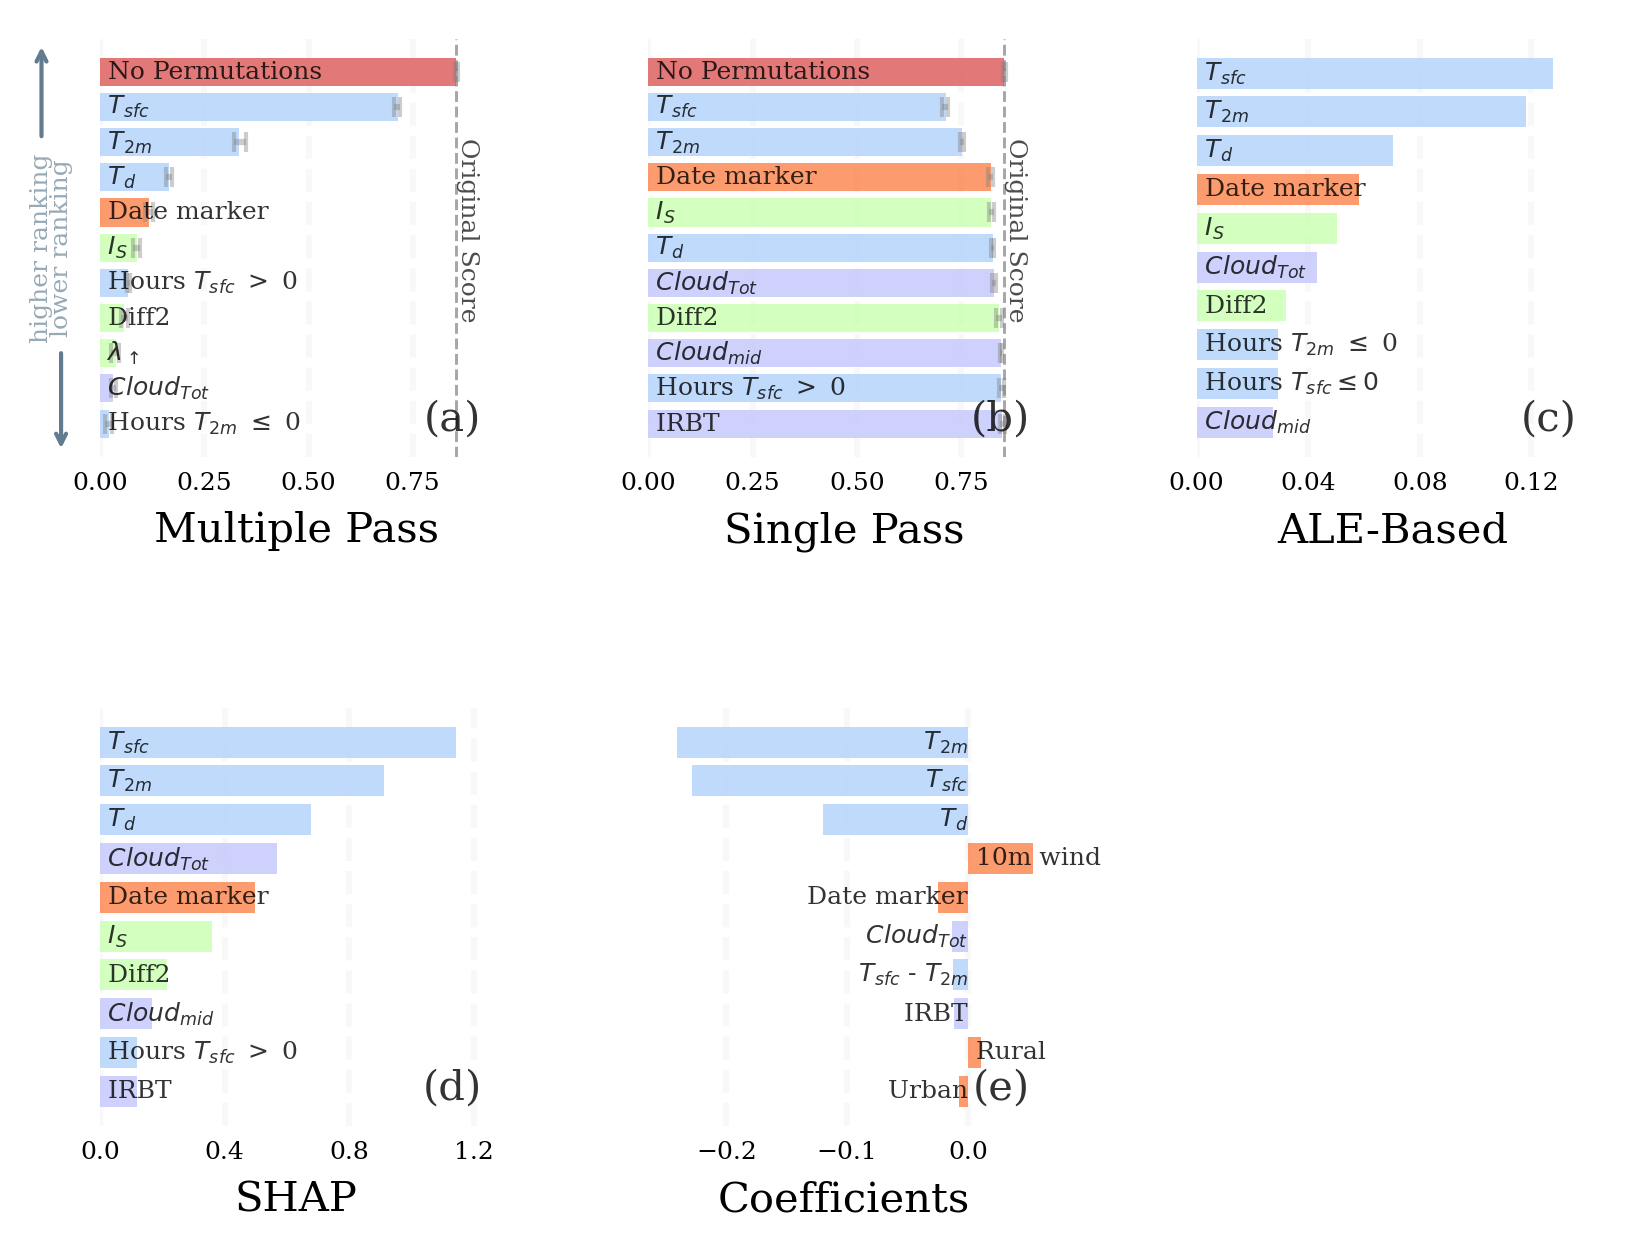

In [8]:
data = [perm_results, perm_results, ale_var_1d,  shap_rank, coef_rank]
panels = [('multipass', 'Logistic Regression'), 
          ('singlepass', 'Logistic Regression'), 
          ('ale_variance', 'Logistic Regression'), 
          ('shap', 'Logistic Regression'), 
          ('coefs', 'Logistic Regression'), 
          ]

fig = explainer.plot_importance(data=data, 
                                panels=panels, 
                                num_vars_to_plot=10, 
                                display_feature_names=plotting_config.display_feature_names,
                                feature_colors=plotting_config.color_dict,
                               )